# Pretrained model on Invasive species classification

## train only with added layers

- The model relies on VGG-16 pretrained model, with `include_top=False`. On top of that, a nn with (1) Dense layer 256 neurons, (2) Output layer 1 neuron, with sigmoid classification.
- This model is revised the previous brutal model, here only the further added top model is trainable.
- Data augmentation is applied upon traing every batch.

## fine tune all bottom layers together with added layers

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
interpolation = cv2.INTER_AREA

## Preprocess training images

In [2]:
master = pd.read_csv("../input/train_labels.csv")
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
y = np.array(y)

#### This group of functions perfrom preprocessing of input training images

- `centering_image`: input `img` has max size 256, and the other dim < 256. This function does zero_padding to make the `img` to size 256 x 256 x 3
- The input raw image is first resized by the same percentage in col and row, the output image is feed to `cetering_image`
- After that, the img is cropped to size 224 x 224 x 3

In [3]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized


X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size, interpolation=interpolation)
    #centering
    img = centering_image(img)
    #out put 224*224px 
    img = img[16:240, 16:240]
    img = img.astype('float32')
    img /= 255.0
    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

## Train-test splitting

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


## Using Keras VGG-16 pretrained model

In [20]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_rows, img_cols, img_channel))

In [21]:
x = base_model.output
x = Flatten()(x)
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.65)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.55)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3, decay=0.95), metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Set the layers of the pretrained vgg16 model to be fixed.

In [23]:
for layer in model.layers[:19]:
    layer.trainable = False

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Model fitting with data augmentation

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 40

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_topmodel.model', monitor='val_acc', save_best_only=True)])

Epoch 1/40
128s - loss: 0.5000 - acc: 0.7752 - val_loss: 1.2303 - val_acc: 0.6580
Epoch 2/40
120s - loss: 0.3586 - acc: 0.8483 - val_loss: 0.3760 - val_acc: 0.8214
Epoch 3/40
117s - loss: 0.3117 - acc: 0.8861 - val_loss: 0.2112 - val_acc: 0.9259
Epoch 4/40
109s - loss: 0.2953 - acc: 0.8863 - val_loss: 0.2682 - val_acc: 0.9194
Epoch 5/40
107s - loss: 0.2748 - acc: 0.8926 - val_loss: 0.6066 - val_acc: 0.8061
Epoch 6/40
107s - loss: 0.2929 - acc: 0.8916 - val_loss: 0.4287 - val_acc: 0.8867
Epoch 7/40
115s - loss: 0.2700 - acc: 0.8970 - val_loss: 0.1908 - val_acc: 0.9281
Epoch 8/40
108s - loss: 0.2555 - acc: 0.9050 - val_loss: 0.2300 - val_acc: 0.9237
Epoch 9/40
115s - loss: 0.2465 - acc: 0.9118 - val_loss: 0.1766 - val_acc: 0.9412
Epoch 10/40
115s - loss: 0.2681 - acc: 0.8949 - val_loss: 0.1736 - val_acc: 0.9434
Epoch 11/40
108s - loss: 0.2394 - acc: 0.9121 - val_loss: 0.2680 - val_acc: 0.9216
Epoch 12/40
108s - loss: 0.2455 - acc: 0.9070 - val_loss: 0.2943 - val_acc: 0.9150
Epoch 13/40
1

### Model prediction on validation images

In [25]:
model.load_weights('VGG16-transferlearning_topmodel.model')
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3, decay=0.95), metrics=['accuracy'])

In [26]:
y_val_pred = model.predict(X_val)

#### Prediction accuracy

In [27]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.956427


#### ROC curve

In [14]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

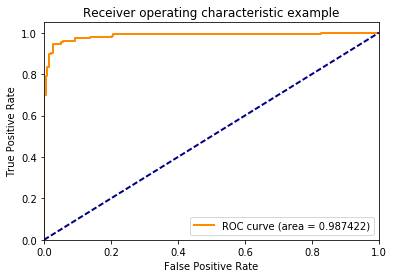

In [15]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Fine-tune the pretrained VGG-16 model plus added layers

In [29]:
for layer in model.layers[15:19]: 
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Start fine tuning with training images

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 40

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history1 = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_finetune.model', monitor='val_acc', save_best_only=True)])

Epoch 1/40
48s - loss: 0.2176 - acc: 0.9194 - val_loss: 0.2286 - val_acc: 0.9237
Epoch 2/40
43s - loss: 0.2184 - acc: 0.9253 - val_loss: 0.4632 - val_acc: 0.7647
Epoch 3/40
42s - loss: 0.2070 - acc: 0.9223 - val_loss: 0.2390 - val_acc: 0.9085
Epoch 4/40
43s - loss: 0.2203 - acc: 0.9141 - val_loss: 0.3712 - val_acc: 0.8279
Epoch 5/40
47s - loss: 0.2272 - acc: 0.9112 - val_loss: 0.1469 - val_acc: 0.9499
Epoch 6/40
43s - loss: 0.2133 - acc: 0.9222 - val_loss: 0.1598 - val_acc: 0.9412
Epoch 7/40
43s - loss: 0.1975 - acc: 0.9264 - val_loss: 0.8989 - val_acc: 0.6057
Epoch 8/40
43s - loss: 0.1682 - acc: 0.9410 - val_loss: 0.3300 - val_acc: 0.8431
Epoch 9/40
43s - loss: 0.2023 - acc: 0.9243 - val_loss: 0.1577 - val_acc: 0.9368
Epoch 10/40
43s - loss: 0.2061 - acc: 0.9255 - val_loss: 0.2332 - val_acc: 0.9259
Epoch 11/40
47s - loss: 0.1808 - acc: 0.9293 - val_loss: 0.1294 - val_acc: 0.9564
Epoch 12/40
43s - loss: 0.1790 - acc: 0.9293 - val_loss: 0.1431 - val_acc: 0.9434
Epoch 13/40
43s - loss: 0

### Model prediction on validation images

In [31]:
model.load_weights('VGG16-transferlearning_finetune.model')
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
y_val_pred = model.predict(X_val)

#### Prediction accuracy

In [32]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.960784


#### ROC curve

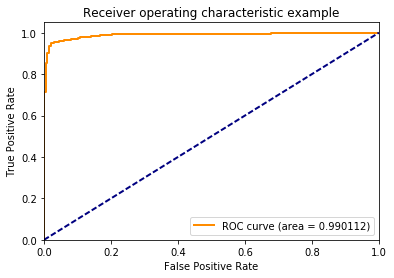

In [33]:
roc_plot(y_val, y_val_pred.reshape(-1))